<a href="https://colab.research.google.com/github/Max-We/sf-zero-signal-to-noise/blob/main/common_diffusion_noise_schedulers_are_flawed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -Uq diffusers transformers fastcore

In [6]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image
from IPython.display import display

logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Introduction

Last week I found an intersting paper on arxiv called "Common Diffusion Noise Schedules and Sample Steps are Flawed". I'm just getting into stable diffusion, but the concepts in the paper were already familiar to me and the changes seemed relatively straight forward. However, the result of these changes seemed incredible.

What is it all about?

Basically the paper claims that current implementations are not able to produce extremely bright or dark images correctly:


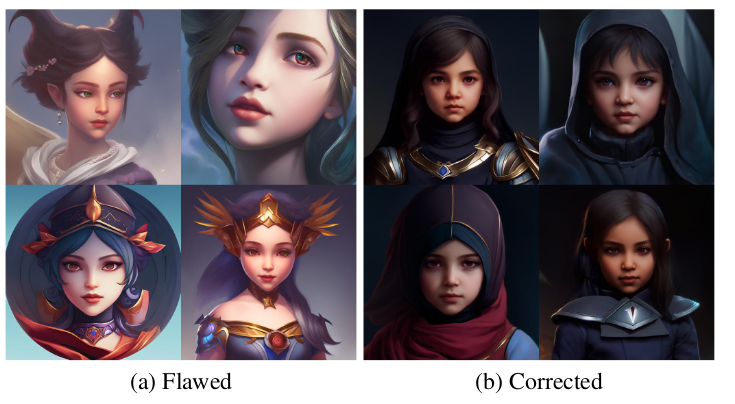

Here's what the problem is and how they try to approach this problem(Abstract):

> We discover that common diffusion noise schedules do not enforce the last timestep to have zero signal-to-noise ratio (SNR), and some implementations of diffusion samplers do not start from the last timestep. Such designs are flawed and do not reflect the fact that the model is given pure Gaussian noise at inference, creating a discrepancy between training and inference. We show that the flawed design causes real problems in existing implementations. In Stable Diffusion, it severely limits the model to only generate images with medium brightness and prevents it from generating very bright and dark samples. We propose a few simple fixes: (1) rescale the noise schedule to enforce zero terminal SNR; (2) train the model with v prediction; (3) change the sampler to always start from the last timestep; (4) rescale classifier-free guidance to prevent over-exposure. These simple changes ensure the diffusion process is congruent between training and inference and allow the model to generate samples more faithful to the original data distribution.

This notebook is my approach to implement the changes from the paper in a real world example. First of all, I will generate images without the fixes from the paper, after that I will introduce the concepts from the paper and provide concrete code that implements them. Finally, I will generate images with these changes and see how it works out.

# Normal inference (no changes)

Based on: https://github.com/fastai/diffusion-nbs/blob/master/stable_diffusion.ipynb

In [7]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from tqdm.auto import tqdm

In [8]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

In [9]:
prompts = [
    "Solid black background",
    #  "Dark city at night" , 
     "A photograph of an astronaut riding a horse", 
    #  "A photograph of a sunny day in central park",
     "A starry sky",
     ]
height, width = 512, 512

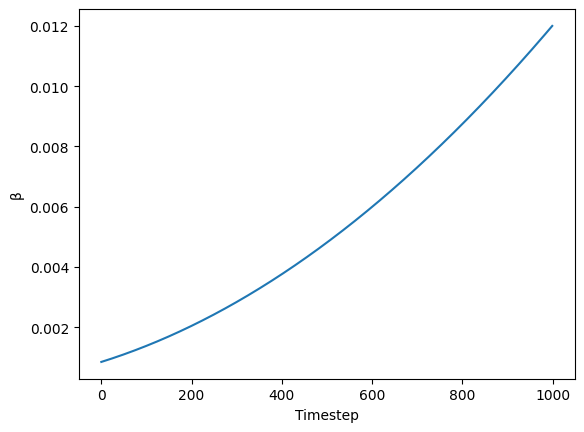

In [10]:
beta_start,beta_end = 0.00085,0.012
train_timesteps, timesteps = 1000, 75
plt.plot(torch.linspace(beta_start**0.5, beta_end**0.5, 1000) ** 2)
plt.xlabel('Timestep')
plt.ylabel('β');

In [11]:
scheduler = PNDMScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=train_timesteps)

In [12]:
scheduler.set_timesteps(timesteps)

In [15]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

In [16]:
def mk_samples(prompt, scheduler, g=7.5, seed=100, steps=70):
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.config.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        # guidance
        pred = u + g*(t-u) # u: unconditional, t: conditional (formula 13 in the paper)
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

In [17]:
images = mk_samples(prompts, scheduler)


  0%|          | 0/79 [00:00<?, ?it/s]

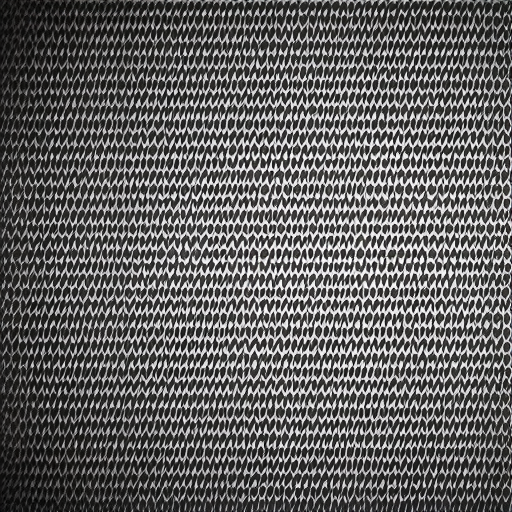

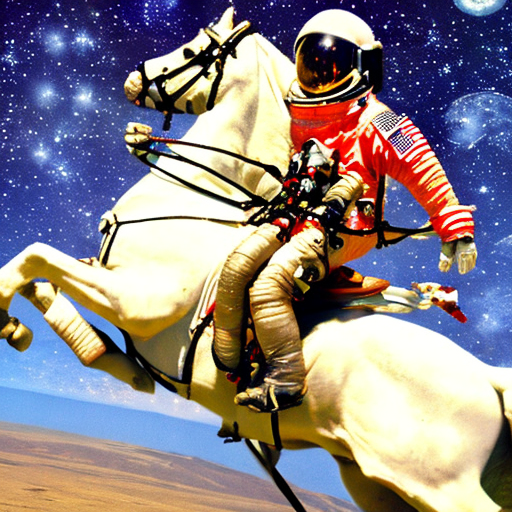

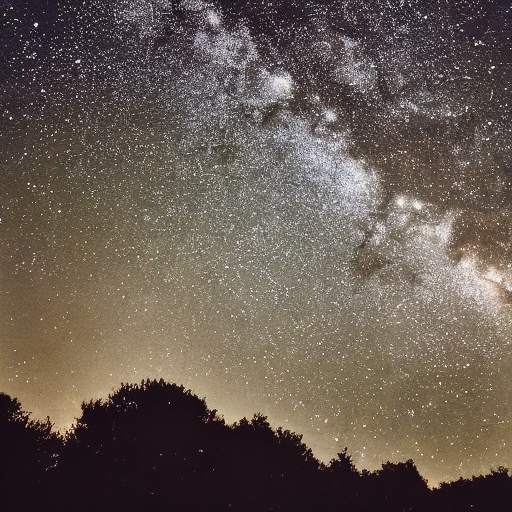

In [18]:
for img in images: display(mk_img(img))

## Zero Signal-to-Noise Ratio

The Paper states the follwoing:


> Common noise schedules, such as linear [3] and cosine [8] schedules, do not enforce the last timestep to have zero signal-to-noise

The solution to this problem is to rescale the betas (amount of noise) of the timesteps

> We argue that noise schedules should always ensure zero SNR on the last timestep and samplers should always start from the last timestep to correctly align diffusion training and inference.

In order to do that, the authors of the paper work with the math of diffusion to make the desired adjustments. To get a good understanding of the math of stable diffusion you can watch this explanaintion: https://www.youtube.com/watch?v=mYpjmM7O-30&feature=youtu.be

The most important formula to know is the following:

$$
q(x_t|x_{t-1}) := \mathcal{N}(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_t \mathbf{I})    
$$

This just describes how much noise there is at each timestep and how it is structured. 

In the paper, there is also an alpha variable, which is defined as: $\alpha_t := 1 - \beta_t$ and $\bar{\alpha}_t := \prod^{t}_{s=1} \alpha_s$.

The operations to fix the SNR are performed on alpha, so the following steps have to be undertaken in order to "fix" the beta:

1. Convert beta to alpha
2. Adjust alpha to produce zero SNR
3. Convert alpha to beta

First of all, let's see how alpha is being changed in order to fix the SNR.


In [25]:
def compare_alpha(betas):
    # Calculate alpha-bar-sqrt
    alphas = 1 - betas
    alphas_bar = alphas.cumprod(0)
    alphas_bar_sqrt = alphas_bar.sqrt()
    original = alphas_bar_sqrt.clone()

    # Store old values.
    alphas_bar_sqrt_0 = alphas_bar_sqrt[0].clone()
    alphas_bar_sqrt_T = alphas_bar_sqrt[-1].clone()

    # Shift so the last timestep is zero.
    alphas_bar_sqrt -= alphas_bar_sqrt_T

    # Scale so the first timestep is back to the old value.
    alphas_bar_sqrt *= alphas_bar_sqrt_0 / (alphas_bar_sqrt_0 - alphas_bar_sqrt_T)

    # Compare
    # plt.plot(custom_betas, label="snr")
    plt.plot(original, label="original")
    plt.plot(alphas_bar_sqrt, label="modified")
    plt.legend()
    plt.xlabel('Timestep')
    plt.ylabel('α');

torch.Size([1000])
torch.Size([1000])


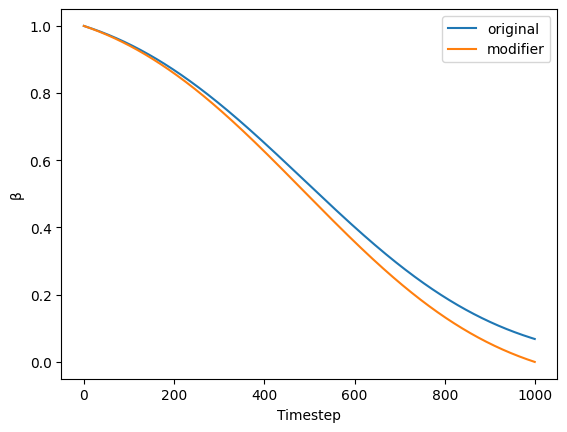

In [26]:
compare_alpha(scheduler.betas)

As you can see, this is the exact same graph as shown in the paper (Figure 2). The changes produce values that are actually zero at the last timestep, which should correct the medium-brightness looking images

This is how the betas compare:

In [38]:
def compare_beta(betas):
    # Calculate alpha-bar-sqrt
    alphas = 1 - betas
    alphas_bar = alphas.cumprod(0)
    alphas_bar_sqrt = alphas_bar.sqrt()
    original = alphas_bar_sqrt.clone()

    # Store old values.
    alphas_bar_sqrt_0 = alphas_bar_sqrt[0].clone()
    alphas_bar_sqrt_T = alphas_bar_sqrt[-1].clone()

    # Shift so the last timestep is zero.
    alphas_bar_sqrt -= alphas_bar_sqrt_T

    # Scale so the first timestep is back to the old value.
    alphas_bar_sqrt *= alphas_bar_sqrt_0 / (alphas_bar_sqrt_0 - alphas_bar_sqrt_T)

    # Convert to betas
    alphas_bar = torch.pow(alphas_bar_sqrt, 2)
    alphas = alphas_bar[1:] / alphas_bar[:-1]
    betas_mod = 1 - alphas

    plt.plot(betas, label="original")
    plt.plot(betas_mod, label="modified")
    plt.legend()
    plt.xlabel('Timestep')
    plt.ylabel('β');

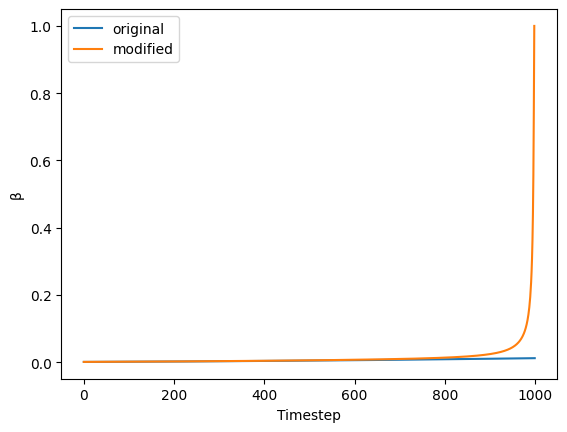

In [39]:
compare_beta(scheduler.betas)

Together, this gives us the algorithm from the paper to "fix" the SNR in the betas:

In [43]:
def enforce_zero_terminal_snr(betas):
    # Convert betas to alphas_bar_sqrt
    alphas = 1 - betas
    alphas_bar = alphas.cumprod(0)
    alphas_bar_sqrt = alphas_bar.sqrt()

    # Store old values.
    alphas_bar_sqrt_0 = alphas_bar_sqrt[0].clone()
    alphas_bar_sqrt_T = alphas_bar_sqrt[-1].clone()

    # Shift so the last timestep is zero.
    alphas_bar_sqrt -= alphas_bar_sqrt_T

    # Scale so the first timestep is back to the old value.
    alphas_bar_sqrt *= alphas_bar_sqrt_0 / (alphas_bar_sqrt_0 - alphas_bar_sqrt_T)

    # Convert alphas_bar_sqrt to betas
    alphas_bar = alphas_bar_sqrt ** 2
    alphas = alphas_bar[1:] / alphas_bar[:-1]
    alphas = torch.cat([alphas_bar[0:1], alphas])
    betas = 1 - alphas

    return betas

# Inference with zero SNR

`PNDMScheduler` provides a parameter `trained_betas` to pass the betas directly. So in order to use a scheduler with the "fixed" betas, we pass our modified tensor.

In [44]:
custom_betas = enforce_zero_terminal_snr(scheduler.betas)

In [45]:
scheduler_snr = PNDMScheduler(trained_betas=custom_betas, num_train_timesteps=train_timesteps)

/usr/local/lib/python3.10/dist-packages/diffusers/schedulers/scheduling_pndm.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.betas = torch.tensor(trained_betas, dtype=torch.float32)


In [46]:
images_snr = mk_samples(prompts, scheduler_snr)

  0%|          | 0/79 [00:00<?, ?it/s]

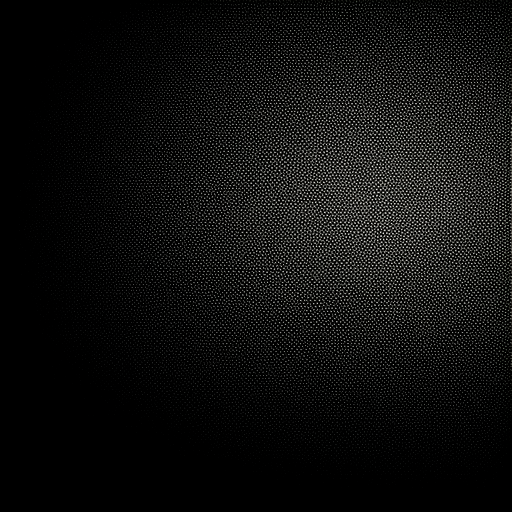

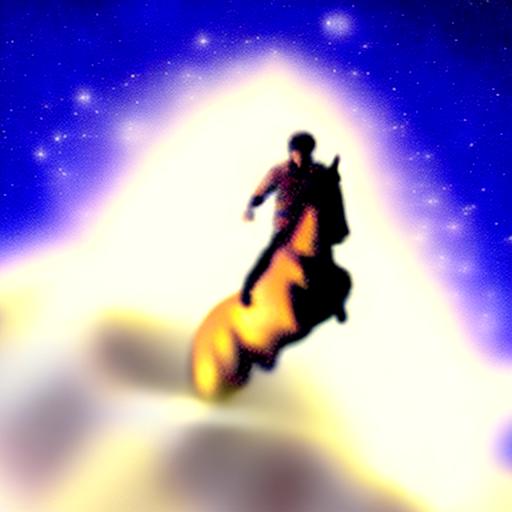

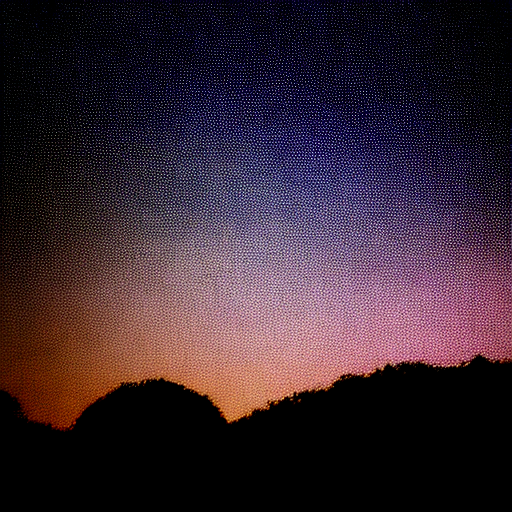

In [47]:
for img in images_snr: display(mk_img(img))

These results don't look very good. This is because of the following reasons mentioned in the paper:

1. Adjusting the betas to zero SNR leads to overexposure (section 3.4)
  - this can be fixed by rescaling the classifier-free guidance (formula 15)
2. The rescaled guidance generates overly plain images
  - this can be fixed by introducing a hyperparameter to control the strength of the rescaling (formula 16)
3. The model we're using for inference here is not fine tuned with the modified betas so it won't produce good images
  - we would have to finetune our own model with all the fixes from this notebook (from the paper)

While I can't fix 3. right now because of missing compute, I will at least implement the solutions for 1. and 2. 

## Fix overexposure & plain looking images

Below is an implementation that applies the fixes from section 3.4

In [4]:
# f is φ in the paper and represents the rescale strength
def mk_samples_rescaled(prompt, scheduler, w=7.5, f=0.7, seed=100, steps=70):
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.config.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): x_neg,x_pos = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

        # perform normal guidance (as before)
        x_cfg = x_neg + w*(x_pos - x_neg) # formula 13

        # calculate standard deviations (used to rescale the results from guidance)
        std_pos = torch.std(x_pos) # formula 14
        std_cfg = torch.std(x_cfg) # formula 14
        # rescale the results from guidance (fixes overexposure)
        x_rescaled = x_cfg * (std_pos / std_cfg) # formula 15
        # mix with the original results from guidance by factor f to avoid plain images
        x_final = f * x_rescaled + (1 - f) * x_cfg # formula 16

        latents = scheduler.step(x_final, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

For comparison, heres the excerpt of section 3.4 from the paper:

We find that as the terminal SNR approaches zero, classifier-free guidance \cite{ho2022classifierfree} becomes very sensitive and can cause images to be overexposed. This problem has been noticed in other works. For example, Imagen \cite{saharia2022photorealistic} uses cosine schedule, which has a near zero terminal SNR, and proposes dynamic thresholding to solve the over-exposure problem. However, the approach is designed only for image-space models. Inspired by it, we propose a new way to rescale classifier-free guidance that is applicable to both image-space and latent-space models.

---

Formula 13:
$$
x_{cfg} = x_{neg} + w (x_{pos} - x_{neg})
$$

---

Equation \ref{eq:cfg} shows regular classifier-free guidance, where $w$ is the guidance weight, $x_{pos}$ and $x_{neg}$ are the model outputs using positive and negative prompts respectively. We find that when $w$ is large, the scale of the resulting $x_{cfg}$ is very big, causing the image over-exposure problem. To solve it, we propose to rescale after applying classifier-free guidance:

---

Formula 14:
$$
\sigma_{pos} = \text{std}(x_{pos}), \quad
\sigma_{cfg} = \text{std}(x_{cfg})
$$

---

Formula 15:
$$
x_{rescaled} = x_{cfg} \cdot \frac{\sigma_{pos}}{\sigma_{cfg}}
$$

---

Formula 16:
$$
x_{final} = \phi \cdot x_{rescaled} + (1 - \phi) \cdot x_{cfg}
$$

---


In Equation 14, we compute the standard deviation of $x_{pos}, x_{cfg}$ as $\sigma_{pos}, \sigma_{cfg} \in \mathbb{R}$. In Equation 15, we rescale $x_{cfg}$ back to the original standard deviation before applying classifier-free guidance but discover that the generated images are overly plain. In Equation 16, we introduce a hyperparameter $\phi$ to control the rescale strength. We empirically find $w=7.5, \phi=0.7$ works great.

Anyways, here are the results with all the improvements proposed in the paper:

In [52]:
images_snr_rescaled = mk_samples_rescaled(prompts, scheduler_snr)

  0%|          | 0/79 [00:00<?, ?it/s]

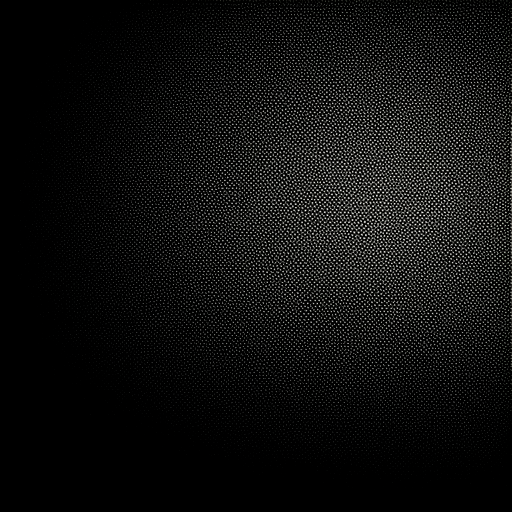

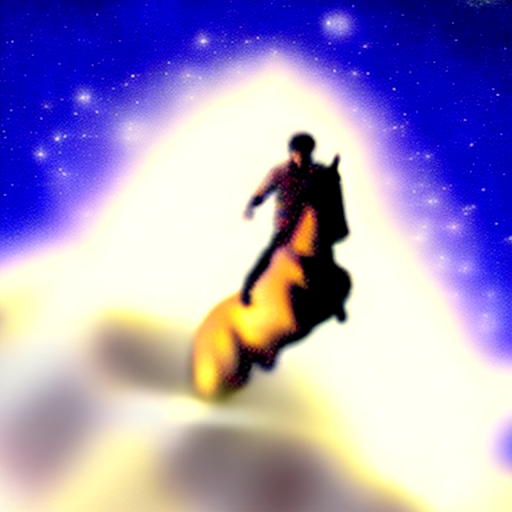

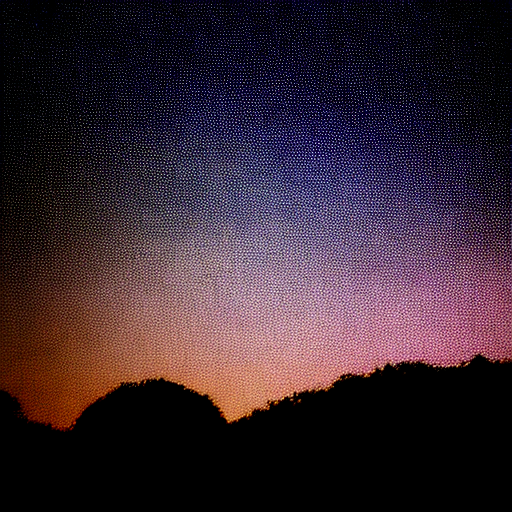

In [53]:
for img in images_snr_rescaled: display(mk_img(img))

As previously mentioned, I would have to fine tune a custom model with theses changes for the results to come through, because right now I'm using a model which is trained without the adjustments on the SNR and guidance. The authors of the paper trained a model on 50K iterations on Laion dataset. If someone wants to try this out, it would certainly be a worthwhile experiment.